# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1310s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1525, 32, 20, 3)
(1525, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
382/382 [==============================] - 4s 8ms/step - loss: 2.2202 - accuracy: 0.2890
Epoch 2/500
382/382 [==============================] - 3s 8ms/step - loss: 1.2717 - accuracy: 0.5778
Epoch 3/500
382/382 [==============================] - 3s 8ms/step - loss: 0.8777 - accuracy: 0.7266
Epoch 4/500
382/382 [==============================] - 3s 8ms/step - loss: 0.6944 - accuracy: 0.7728
Epoch 5/500
382/382 [==============================] - 3s 8ms/step - loss: 0.6529 - accuracy: 0.8068
Epoch 6/500
382/382 [==============================] - 3s 8ms/step - loss: 0.5786 - accuracy: 0.8221
Epoch 7/500
382/382 [==============================] - 3s 8ms/step - loss: 0.5496 - accuracy: 0.8565
Epoch 8/500
382/382 [==============================] - 4s 10ms/step - loss: 0.4475 - accuracy: 0.8632 0s - loss: 0.4474 - accuracy: 0.86
Epoch 9/500
382/382 [==============================] - 4s 11ms/step - loss: 0.4171 - accuracy: 0.8681
Epoch 10/500
382/382 [==============================] 

382/382 [==============================] - 5s 12ms/step - loss: 0.0974 - accuracy: 0.9754
Epoch 81/500
382/382 [==============================] - 5s 12ms/step - loss: 0.1005 - accuracy: 0.9734
Epoch 82/500
382/382 [==============================] - 5s 13ms/step - loss: 0.0635 - accuracy: 0.9796
Epoch 83/500
382/382 [==============================] - 5s 13ms/step - loss: 0.0758 - accuracy: 0.9778
Epoch 84/500
382/382 [==============================] - 5s 13ms/step - loss: 0.0857 - accuracy: 0.9726
Epoch 85/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0617 - accuracy: 0.9865
Epoch 86/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0626 - accuracy: 0.9762
Epoch 87/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0619 - accuracy: 0.9839
Epoch 88/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0657 - accuracy: 0.9801
Epoch 89/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0869 - 

382/382 [==============================] - 5s 12ms/step - loss: 0.0530 - accuracy: 0.9826
Epoch 158/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0346 - accuracy: 0.9915
Epoch 159/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0193 - accuracy: 0.9918
Epoch 160/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0419 - accuracy: 0.9861
Epoch 161/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0405 - accuracy: 0.9884
Epoch 162/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0714 - accuracy: 0.9818
Epoch 163/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0473 - accuracy: 0.9847
Epoch 164/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0437 - accuracy: 0.9834 0s - loss:
Epoch 165/500
382/382 [==============================] - 4s 12ms/step - loss: 0.0327 - accuracy: 0.9907
Epoch 166/500
382/382 [==============================] - 5s 12ms/st

382/382 [==============================] - 5s 12ms/step - loss: 0.0431 - accuracy: 0.9891
Epoch 267/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0572 - accuracy: 0.9927
Epoch 268/500
382/382 [==============================] - 4s 12ms/step - loss: 0.0467 - accuracy: 0.9922 3s
Epoch 269/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0282 - accuracy: 0.9954
Epoch 270/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0273 - accuracy: 0.9940
Epoch 271/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0113 - accuracy: 0.9947
Epoch 272/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0110 - accuracy: 0.9966
Epoch 273/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0293 - accuracy: 0.9928
Epoch 274/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0464 - accuracy: 0.9931
Epoch 275/500
382/382 [==============================] - 5s 12ms/step - los

382/382 [==============================] - 5s 13ms/step - loss: 0.0037 - accuracy: 0.9990
Epoch 373/500
382/382 [==============================] - 5s 13ms/step - loss: 0.0475 - accuracy: 0.9908
Epoch 374/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0196 - accuracy: 0.9964
Epoch 375/500
382/382 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.99 - 5s 13ms/step - loss: 0.0195 - accuracy: 0.9944
Epoch 376/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0145 - accuracy: 0.9954
Epoch 377/500
382/382 [==============================] - 5s 13ms/step - loss: 0.0131 - accuracy: 0.9978 0s - loss: 0.0132 
Epoch 378/500
382/382 [==============================] - 5s 13ms/step - loss: 0.0203 - accuracy: 0.9966
Epoch 379/500
382/382 [==============================] - 5s 13ms/step - loss: 0.0330 - accuracy: 0.9920
Epoch 380/500
382/382 [==============================] - 5s 12ms/step - loss: 0.0158 - accuracy: 0.9969
Epoch 381/500
382

382/382 [==============================] - 2s 6ms/step - loss: 0.0295 - accuracy: 0.9936
Epoch 451/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0143 - accuracy: 0.9961
Epoch 452/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0067 - accuracy: 0.9983
Epoch 453/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0037 - accuracy: 0.9991
Epoch 454/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0246 - accuracy: 0.9928
Epoch 455/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0262 - accuracy: 0.9970
Epoch 456/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 457/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0372 - accuracy: 0.9904
Epoch 458/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0068 - accuracy: 0.9987
Epoch 459/500
382/382 [==============================] - 2s 6ms/step - loss: 0.0252 - a

### Learing result
 
* Visualization of the training and validation results

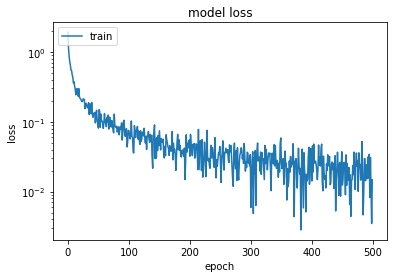

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\0_D6_2020-08-16_01-02-52.jpg 0 9


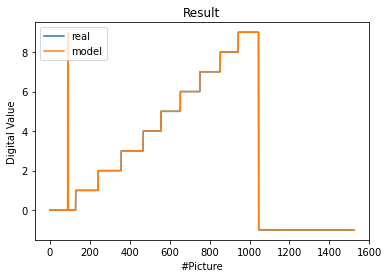

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpzhli48yu\assets


1303008

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpoutz76ss\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpoutz76ss\assets


dig1310s1q.tflite


338112

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.